# Rover Analytics

## Question 1:  For uncancelled bookings, are owners or providers more likely to leave a review?  Which tends to leave better reviews?

In [7]:
import sqlite3
from sqlite3 import Error
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import datetime as dt

In [2]:
conversations = pd.read_csv('csvs/conversations_conversation.csv')

In [3]:
conv_pets = pd.read_csv('csvs/conversations_conversation_pets.csv')

In [4]:
conv_message = pd.read_csv('csvs/conversations_message.csv')

In [5]:
conv_review = pd.read_csv('csvs/conversations_review.csv')

In [6]:
services = pd.read_csv('csvs/services_service.csv')

In [202]:
services.head(1) #provider_id matches people_person

,id,service_type,cancellation_policy,can_provide_oral_medication,can_provide_injected_medication,senior_dog_experience,special_needs_experience,takes_small_dogs,takes_medium_dogs,takes_large_dogs,takes_puppies,max_dogs,provider_id,fee,price,added
0,1,boarding,strict,1,1,1,1,0,1,1,1,4,1,0.15,35,2016-08-02 14:59:15.095591


In [19]:
conversations.head(1) #requester_id matches people_person #service_id matches services_service

,id,start_date,end_date,units,added,booking_total,cancellation_fault,requester_id,service_id,booked_at,cancelled_at
0,1,2018-07-26,2018-07-31,5,2018-07-16 10:17:53.460035,120,NaN,64393,4646,NaN,NaN


In [78]:
conv_pets.head(10) #conv_id goes to conversation_conversation booking id

,id,conversation_id,pet_id
0,1,1,77730
1,2,2,77729
2,3,3,77728
3,4,3,77727
4,5,4,77728
5,6,4,77727
6,7,5,77725
7,8,6,77724
8,9,7,77721
9,10,8,77720


In [79]:
conv_message.head(10)  #conversation_id matches with conversation_conversation id


,id,sent,content,conversation_id,sender_id
0,1,2018-07-16 10:17:53.460035,Massa class.,1,64393
1,2,2018-07-28 16:53:53.927200,Porta lorem ornare condimentum.,1,2709
2,3,2018-07-16 23:55:22.904038,Neque curae rutrum elit conubia metus in.,1,2709
3,4,2018-07-23 10:05:49.829926,Donec etiam gravida luctus tellus phasellus ri...,1,2709
4,5,2018-08-01 10:20:48.626868,Risus class dui leo sem dui sed sollicitudin.,2,64392
5,6,2018-08-04 06:30:51.768397,Netus lacus.,2,64392
6,7,2018-08-04 15:23:40.023422,Velit augue accumsan amet orci parturient quis...,2,5927
7,8,2018-06-05 16:46:39.542467,Fames proin eros phasellus in id lectus et sed.,3,64391
8,9,2018-06-12 15:42:24.700658,Augue netus.,3,12177
9,10,2018-06-07 04:54:57.047007,Velit augue scelerisque vehicula proin.,3,12177


In [236]:
message_number = conv_message['conversation_id'].value_counts() 
#get the number of messages for each conversation_conversation id

In [281]:
message_sender = conv_message.groupby(['conversation_id']).size().reset_index()
message_sender.columns = ['conversation_id', 'conv_counts']
message_sender.head()

,conversation_id,conv_counts
0,1,4
1,2,3
2,3,3
3,4,6
4,5,5


In [87]:
conv_review.head(10) #conversation_id matches to conversations_conversation. reviewer_id matches people_person

,id,content,stars,conversation_id,reviewer_id
0,1,Netus proin per duis dolor venenatis nam.,1,7,64386
1,2,Dolor proin donec phasellus ve suspendisse ac ...,5,9,64384
2,3,Proin ipsum urna nisl egestas justo class a ar...,5,11,64382
3,4,Porta velit lectus varius donec tellus sollici...,1,13,64381
4,5,Dolor felis.,2,15,64379
5,6,Risus justo risus blandit iaculis.,5,19,64373
6,7,Porta proin ridiculus vestibulum gravida orci ...,5,19,11942
7,8,Metus ipsum.,5,25,64366
8,9,Dolor netus nec.,2,26,64365
9,10,Fusce class non primis duis eros potenti ac.,3,26,12441


In [38]:
conv_cancelled = conversations[(~conversations['booked_at'].isna()) & (~conversations['cancelled_at'].isna())]

In [39]:
conv_cancelled.head()

,id,start_date,end_date,units,added,booking_total,cancellation_fault,requester_id,service_id,booked_at,cancelled_at
17,18,2018-08-01,2018-08-07,6,2018-07-23 18:11:08.524151,288,requester,64376,18503,2018-07-28 02:24:41.829042,2018-07-31 09:09:27.965552
21,22,2018-06-14,2018-06-19,5,2018-06-05 06:44:01.985076,250,provider,64370,10339,2018-06-09 16:06:08.532196,2018-06-12 04:02:21.445353
54,55,2018-07-27,2018-07-29,2,2018-07-15 07:15:39.875647,92,provider,64336,364,2018-07-19 20:52:38.495156,2018-07-23 22:26:14.972345
62,63,2018-07-29,2018-07-30,1,2018-07-20 17:56:50.838856,19,requester,64328,2254,2018-07-25 06:59:53.310767,2018-07-27 01:58:12.079901
96,97,2018-06-27,2018-06-30,3,2018-06-19 07:48:41.185276,252,provider,64290,7880,2018-06-21 20:34:29.065315,2018-06-25 05:18:47.415560


In [40]:
conv_not_cancelled = conversations[(~conversations['booked_at'].isna()) & (conversations['cancelled_at'].isna())]

In [47]:
conv_not_cancelled.head()

,id,start_date,end_date,units,added,booking_total,cancellation_fault,requester_id,service_id,booked_at,cancelled_at
5,6,2018-07-04,2018-07-07,3,2018-06-23 16:16:16.891344,78,NaN,64388,14772,2018-06-27 14:39:51.433544,NaN
6,7,2018-07-31,2018-08-04,4,2018-07-21 04:55:57.951572,100,NaN,64386,14783,2018-07-22 02:50:20.676664,NaN
8,9,2018-07-02,2018-07-03,1,2018-06-21 06:23:08.092389,23,NaN,64384,7656,2018-06-23 01:49:33.596667,NaN
10,11,2018-06-12,2018-06-18,6,2018-06-03 09:11:33.421951,300,NaN,64382,2512,2018-06-07 01:24:20.187356,NaN
12,13,2018-07-24,2018-07-27,3,2018-07-13 10:30:05.875588,126,NaN,64381,1634,2018-07-19 01:01:11.552880,NaN


In [122]:
conv_uncertain = conversations[(conversations['booked_at'].isna()) & (conversations['cancelled_at'].isna())]
conv_uncertain.describe()
#no booking or cancellation data

,id,units,booking_total,requester_id,service_id
count,46714.000000,46714.000000,46714.000000,46714.000000,46714.000000
mean,40074.750653,4.288907,183.031746,38058.799139,10484.822237
std,23155.210110,2.013765,142.764792,14770.327846,6339.537338
min,1.000000,1.000000,16.000000,12601.000000,1.000000
25%,20086.500000,3.000000,88.000000,25273.250000,4959.000000
50%,40121.500000,4.000000,140.000000,37952.000000,10523.000000
75%,60132.500000,6.000000,240.000000,50792.000000,15980.750000
max,80180.000000,10.000000,1320.000000,64393.000000,21398.000000


In [45]:
conv_cancelled.describe()

,id,units,booking_total,requester_id,service_id
count,3373.000000,3373.000000,3373.000000,3373.000000,3373.000000
mean,39924.240142,4.237771,178.520012,38154.245775,10628.567744
std,23275.850841,2.040174,146.717652,14847.116726,6357.673954
min,18.000000,1.000000,16.000000,12619.000000,8.000000
25%,18809.000000,3.000000,84.000000,25035.000000,5010.000000
50%,40084.000000,4.000000,135.000000,37979.000000,10709.000000
75%,60523.000000,6.000000,231.000000,51598.000000,16081.000000
max,80148.000000,10.000000,1200.000000,64376.000000,21374.000000


In [46]:
conv_not_cancelled.describe()

,id,units,booking_total,requester_id,service_id
count,30093.000000,30093.000000,30093.000000,30093.000000,30093.000000
mean,40133.583425,4.225634,177.388396,38021.374040,10545.431795
std,23118.056223,2.030408,142.670698,14747.352548,6322.089688
min,6.000000,1.000000,15.000000,12603.000000,1.000000
25%,20103.000000,3.000000,84.000000,25289.000000,5018.000000
50%,40049.000000,4.000000,136.000000,37996.000000,10567.000000
75%,60109.000000,6.000000,231.000000,50782.000000,16038.000000
max,80175.000000,10.000000,1260.000000,64388.000000,21398.000000


In [54]:
owners = conv_not_cancelled['requester_id']
sum(owners.isna()) #no missing values

0

In [55]:
provider_num = conv_not_cancelled['service_id']
sum(provider_num.isna())

0

### Join the bookings table with the reviews table where id = conversations_id

In [84]:
request_reviews = pd.merge(left=conv_not_cancelled, right=conv_review, 
                  left_on=conv_not_cancelled['id'], right_on=conv_review['conversation_id'])

In [188]:
request_reviews.head(1)

,key_0,id_x,start_date,end_date,units,added,booking_total,cancellation_fault,requester_id,service_id,booked_at,cancelled_at,id_y,content,stars,conversation_id,reviewer_id
0,7,7,2018-07-31,2018-08-04,4,2018-07-21 04:55:57.951572,100,NaN,64386,14783,2018-07-22 02:50:20.676664,NaN,1,Netus proin per duis dolor venenatis nam.,1,7,64386


In [67]:
provider_not_cancelled = services[services['id'].isin(conv_not_cancelled['service_id'].values)]

In [74]:
provider_ids = provider_ids['provider_id']


In [71]:
provider_ids = provider_ids.unique()

In [77]:
len(provider_ids)

8927

In [80]:
senders = conv_message[conv_message['conversation_id'].isin(conv_not_cancelled['id'])]

In [82]:
senders_ids = senders['sender_id'].unique()

In [90]:
not_cancelled_reviews = conv_review[conv_review['conversation_id'].isin(conv_not_cancelled['id'])]

In [123]:
cancelled_reviews = conv_review[conv_review['conversation_id'].isin(conv_cancelled['id'])]
cancelled_reviews #cancelled bookings don't have reviews

,id,content,stars,conversation_id,reviewer_id


In [125]:
uncertain_reviews = conv_review[conv_review['conversation_id'].isin(conv_uncertain['id'])]
uncertain_reviews #uncertain bookings don't have reviews

,id,content,stars,conversation_id,reviewer_id


In [97]:
requesters = not_cancelled_reviews[not_cancelled_reviews['reviewer_id'].isin(conv_not_cancelled['requester_id'])]
len(requesters)

22499

In [99]:
providers = not_cancelled_reviews[~not_cancelled_reviews['reviewer_id'].isin(conv_not_cancelled['requester_id'])]
len(providers)

6062

In [95]:
22499/28561  #78.8 percent of reviews from non-cancelled bookings are from the requester

0.7877525296733308

In [194]:
providers['stars'].value_counts() #counts for the number in each category

5    3397
4     693
1     679
3     649
2     644
Name: stars, dtype: int64

In [201]:
providers['booking_total'].mean()

180.06647970966677

Text(0.5,1,'Histogram of Provider ratings for Uncancelled Bookings')

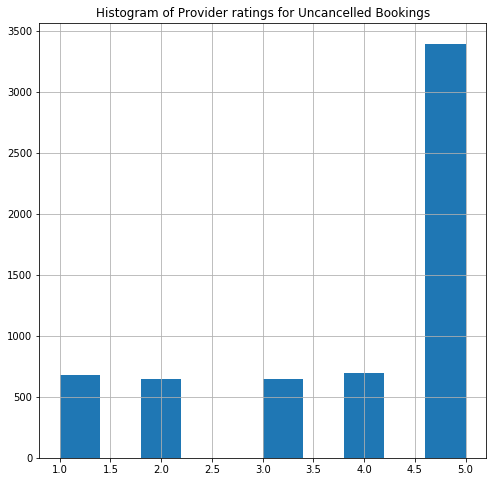

In [117]:
fig, ax = plt.subplots(figsize = (8,8))
providers['stars'].hist()
ax.set_title("Histogram of Provider ratings for Uncancelled Bookings")

In [195]:
requesters['stars'].value_counts()

5    17227
4     1339
1     1318
3     1313
2     1302
Name: stars, dtype: int64

Text(0.5,1,'Histogram of Requester ratings for Uncancelled Bookings')

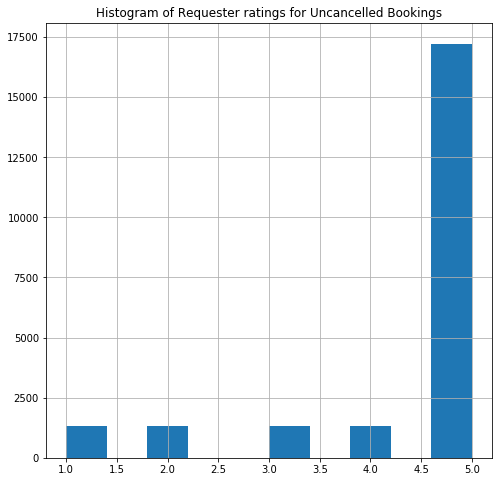

In [116]:
fig, ax = plt.subplots(figsize = (8,8))
requesters['stars'].hist()
ax.set_title("Histogram of Requester ratings for Uncancelled Bookings")

In [186]:
providers['stars'].mean() #average rating for providers

3.9048168921148134

In [187]:

requesters['stars'].mean() #average rating for customers

4.41584070403129

### Compute a Random Effects model of interaction ratings with Providers or Requesters as the predictor variable.
### Control for multiple ratings within each user with a random effects linear model.

In [144]:
import statsmodels.api as statsm
import statsmodels.formula.api as smf

### Rater id (0 being requesters and 1 being providers) is predictive of rating levels.  Providers rate interactions
### lower than requesters.  

In [164]:
#merged table of not cancelled bookings in conversations_conversation table with conversations_review table
request_reviews = pd.merge(left=conv_not_cancelled, right=conv_review, 
                  left_on=conv_not_cancelled['id'], right_on=conv_review['conversation_id'])

In [165]:
len(request_reviews)

28561

In [166]:
#just the provider reviews
providers = request_reviews[~request_reviews['reviewer_id'].isin(request_reviews['requester_id'])]

In [168]:
#just the requester reviews
requesters = request_reviews[request_reviews['reviewer_id'].isin(request_reviews['requester_id'])]

In [171]:
providers['id'] = 1
requesters['id'] = 0

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [172]:
ratings = pd.concat([providers, requesters])

In [174]:
ratings.head(1)

,key_0,id_x,start_date,end_date,units,added,booking_total,cancellation_fault,requester_id,service_id,booked_at,cancelled_at,id_y,content,stars,conversation_id,reviewer_id,id
6,19,19,2018-08-04,2018-08-05,1,2018-07-26 13:37:10.568236,29,NaN,64373,20273,2018-07-29 02:10:09.571217,NaN,7,Porta proin ridiculus vestibulum gravida orci ...,5,19,11942,1


In [178]:
rand_eff = smf.mixedlm('stars ~ id + units + booking_total + units*booking_total', 
                       ratings, groups=ratings['reviewer_id'])

In [179]:
rand_eff_fit = rand_eff.fit()

In [180]:
rand_eff_fit.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
             Mixed Linear Model Regression Results
===============================================================
Model:              MixedLM   Dependent Variable:   stars      
No. Observations:   28561     Method:               REML       
No. Groups:         22420     Scale:                1.5310     
Min. group size:    1         Likelihood:           -46852.5912
Max. group size:    7         Converged:            Yes        
Mean group size:    1.3                                        
---------------------------------------------------------------
                    Coef.  Std.Err.    z    P>|z| [0.025 0.975]
---------------------------------------------------------------
Intercept            4.462    0.025 179.360 0.000  4.413  4.511
id                  -0.510    0.018 -28.099 0.000 -0.546 -0.475
units               -0.008    0.006  -1.386 0.166 -0.019  0.003
booking_total       -0.000    0.000  -2.037 0.042 -0.001 -0.000
units:booking_total  0.000    0.000   2.311 0.021  0.000  0.000
Group Var            0.023    0.014                            
===============================================================

"""

In [185]:
rand_eff_2 = smf.mixedlm('stars ~ id + units + booking_total', 
                       ratings, groups=ratings['reviewer_id']) #no interaction term between units and booking

In [183]:
rand_eff_2_fit = rand_eff_2.fit()

In [184]:
rand_eff_2_fit.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
          Mixed Linear Model Regression Results
=========================================================
Model:            MixedLM Dependent Variable: stars      
No. Observations: 28561   Method:             REML       
No. Groups:       22420   Scale:              1.5312     
Min. group size:  1       Likelihood:         -46845.3740
Max. group size:  7       Converged:          Yes        
Mean group size:  1.3                                    
---------------------------------------------------------
              Coef.  Std.Err.    z    P>|z| [0.025 0.975]
---------------------------------------------------------
Intercept      4.421    0.018 251.584 0.000  4.387  4.456
id            -0.510    0.018 -28.104 0.000 -0.546 -0.475
units         -0.001    0.005  -0.296 0.767 -0.011  0.008
booking_total  0.000    0.000   0.054 0.957 -0.000  0.000
Group Var      0.023    0.014                            
=========================================================

"""

### Summary:
For all bookings that were not cancelled, both the owner and the provider were allowed to give reviews of the experience.  Of all the reviews, 78.78% of those reviews were from the owners. The remaining reviews were by the providers.  Both owners and providers tended to leave positive reviews on the likert scale rating (scale of 1 to 5, with 5 being the best).  Owners tended to rate their experience more positively than providers (means of 4.4156 and 3.9, respectively).  A regression model including provider/owner identification, booking total, booking units, and a booking units by booking total interaction indicated that rating was influenced by provider/owner identification, holding all the other predictors in the model constant, and controlling rating tendencies among reviewers with multiple reviews.  Thus, owners tend to rate their experiences more positively than providers, and booking total, number of units booked, or some combination of these two variables has little influence on the rating outcome.

These data indicate that, overall, our owners and providers are satisfied with their services. Providers don't tend to rate as often as owners, and when they do their ratings are a bit more spread out over the scale.  This may be due to an underreporting bias among the providers.  Providers with satisfactory experiences may not be submitting reviews because of a lack of perceived consequence for their actions:  if they report a positive experience, will it affect their incomming business or their future bookings? If not, the extra time to submit a rating may not be deemed necessary.  Reporting negative experiences may be important for flagging dangerous situations, and thus the reporting at the lower levels may be more representative of the actual frequency of negative experiences.  Knowing the true frequency of negative to positive experiences is important for business, as negative experiences could lead to providers leaving the company, or jumping to a competitor, and we should calculate for those percentages accurately in our strategic planning. Thus, we should see what barriers exist that reduce rating frequencies among providers, and offer incentives to increase review reporting frequency.

While owners on average had very positive experiences with their booking, it is worth noting that 2,620 of the owners rated the experience as a 1 or 2.  The average booking is around 180.00 USD. So, if owners do not return to us in the future, that is a loss of 471,600.00 USD, assuming they would have booked one more time.  Over the years, the actual loss is likely much higher as owners would presumably have multiple bookings each year.  Looking at ways we can retain the customers who provided low ratings, and reduce the number of 1s and 2s among our owner ratings, should be a priority.


In [293]:
request_reviews_counts = pd.merge(left=ratings, right=message_counts, 
                                  left_on=ratings['conversation_id'], right_on=message_counts['conversation'])

ValueError: cannot insert key_0, already exists

In [283]:
message_counts = message_sender[message_sender['conversation_id'].isin(ratings['conversation_id'])]

In [286]:
message_counts.columns = ['conversation', 'conv_counts']

In [292]:
message_counts = message_counts.reset_index()